# **Text Classification: Language Anxiety**

## **Importing Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer

## Set random seed for reproducibility

In [ ]:
seed = 2025
np.random.seed(seed)
random.seed(seed)

## **Reading The Dataset**

In [ ]:
df = pd.read_excel('/content/dataset_2class_better.xlsx')
df.head()

,shortname,idnumber,firstname,lastname,thread,Post,charcount,wordcount,postdate,id,...,Saya merasa tidak percaya diri dengan keahlian menulis saya dalam Bahasa Inggris,Saya merasa gugup ketika menghadapi test menulis dalam Bahasa Inggris,Saya khawatir komposisi bahasa Inggris saya akan dikritik,Saya merasa malu melihat nilai buruk dari karangan Bahasa Inggris saya,Saya takut teman-teman akan mengkritik hasil tulisan saya dalam Bahasa Inggris,Saya merasa cemas tulisan saya dalam Bahasa Inggris akan tampak lucu,Saya takut menulis kepada penutur asli bahasa Inggris,Kelas,LA MEAN,LA Class
0,UWJXA2-KM-46-GAB0304,1502223094,KHALIESAH,AQILAH,Khaliesah Aqilah,The place I've been to that I love and always ...,502,109,2024-02-27 13:46:10,2541902,...,3,3,3,3,3,3,4,KM-46-04,3.1,Anxiety
1,UWJXA2-KM-46-GAB0304,1502223341,NISRINA,NORAMALIA FITRI,Nisrina Noramalia,"My favorite place is Hat Yai in Thailand, spec...",687,152,2024-02-27 13:53:14,2541929,...,3,3,4,2,2,2,2,KM-46-04,2.5,Anxiety
2,UWJXA2-KM-46-GAB0304,1502223015,KALILA,QUEENTANIA,Kalila Queentania,One of my favorite places that i have been vis...,937,225,2024-02-27 13:53:42,2541930,...,2,3,2,2,3,3,1,km 46-03,2.1,No Anxiety
3,UWJXA2-KM-46-GAB0304,1502223016,RATNA,MEITA ARIANTARI PUTRI,Ratna Meita Ariantari Putri,"When I was in 6th grade, I went on a vacation ...",677,167,2024-02-27 13:53:42,2541931,...,3,3,3,3,3,3,3,KM 46 04,3.0,Anxiety
4,UWJXA2-KM-46-GAB0304,1502223251,NITA,NABILA,Nita Nabila,"My favorite place is Bali, I like Bali so much...",621,151,2024-02-27 13:53:54,2541932,...,3,3,4,4,4,4,3,KM-46-04,3.4,Anxiety


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 25 columns):
 #   Column                                                                                                                                                                              Non-Null Count  Dtype         
---  ------                                                                                                                                                                              --------------  -----         
 0   shortname                                                                                                                                                                           324 non-null    object        
 1   idnumber                                                                                                                                                                            324 non-null    int64         
 2   firstname                 

## **Checking Class Distribution**

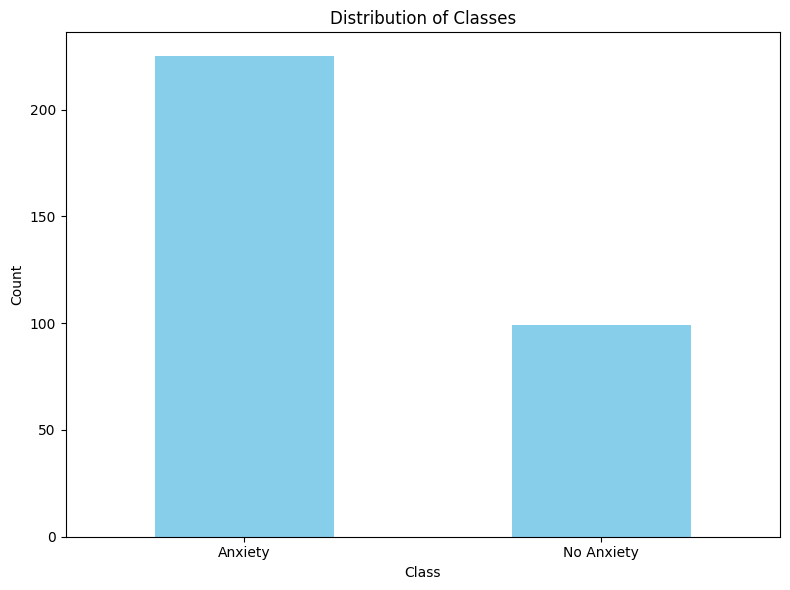

In [ ]:
# Mengambil nilai perhitungan distribusi kelas
class_counts = df['LA Class'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

## **Encode The Target Variable**

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Class'].map({'Anxiety': 1, 'No Anxiety': 0})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Class', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Class'], inplace=True)

Mapping kelas ke nilai encoded:
       LA Class  la_class
0       Anxiety         1
1       Anxiety         1
2    No Anxiety         0
3       Anxiety         1
4       Anxiety         1
..          ...       ...
319     Anxiety         1
320     Anxiety         1
321  No Anxiety         0
322     Anxiety         1
323     Anxiety         1

[324 rows x 2 columns]


In [ ]:
df

,shortname,idnumber,firstname,lastname,thread,Post,charcount,wordcount,postdate,id,...,Saya merasa tidak percaya diri dengan keahlian menulis saya dalam Bahasa Inggris,Saya merasa gugup ketika menghadapi test menulis dalam Bahasa Inggris,Saya khawatir komposisi bahasa Inggris saya akan dikritik,Saya merasa malu melihat nilai buruk dari karangan Bahasa Inggris saya,Saya takut teman-teman akan mengkritik hasil tulisan saya dalam Bahasa Inggris,Saya merasa cemas tulisan saya dalam Bahasa Inggris akan tampak lucu,Saya takut menulis kepada penutur asli bahasa Inggris,Kelas,LA MEAN,la_class
0,UWJXA2-KM-46-GAB0304,1502223094,KHALIESAH,AQILAH,Khaliesah Aqilah,The place I've been to that I love and always ...,502,109,2024-02-27 13:46:10,2541902,...,3,3,3,3,3,3,4,KM-46-04,3.1,1
1,UWJXA2-KM-46-GAB0304,1502223341,NISRINA,NORAMALIA FITRI,Nisrina Noramalia,"My favorite place is Hat Yai in Thailand, spec...",687,152,2024-02-27 13:53:14,2541929,...,3,3,4,2,2,2,2,KM-46-04,2.5,1
2,UWJXA2-KM-46-GAB0304,1502223015,KALILA,QUEENTANIA,Kalila Queentania,One of my favorite places that i have been vis...,937,225,2024-02-27 13:53:42,2541930,...,2,3,2,2,3,3,1,km 46-03,2.1,0
3,UWJXA2-KM-46-GAB0304,1502223016,RATNA,MEITA ARIANTARI PUTRI,Ratna Meita Ariantari Putri,"When I was in 6th grade, I went on a vacation ...",677,167,2024-02-27 13:53:42,2541931,...,3,3,3,3,3,3,3,KM 46 04,3.0,1
4,UWJXA2-KM-46-GAB0304,1502223251,NITA,NABILA,Nita Nabila,"My favorite place is Bali, I like Bali so much...",621,151,2024-02-27 13:53:54,2541932,...,3,3,4,4,4,4,3,KM-46-04,3.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,UWJXA2-KM-46-GAB0708,1502220397,FATHIR,REIHAN MUSA,Fathir Reihan M,"My favorite place is Bandung, a tempting city ...",1016,187,2024-03-04 09:52:33,2556242,...,5,4,5,5,3,3,4,KM 46 - 07,4.0,1
320,UWJXA2-KM-46-GAB0102,1502220222,RAIHANAH,ZHAFIRA ZAHRA,Raihanah Zhafira Zahra_1502220222,The viral place I visited was the Banda Aceh\n...,1231,270,2024-03-04 23:34:22,2558120,...,3,3,3,3,3,3,3,Km-46-01,3.0,1
321,UWJXA2-KM-46-GAB0102,1502223077,ZAHRA,NAZELINA PUTRI,Zahra Nazelina Putri_1502223077,My Favorite PlacesI was about 11 or 12 years o...,1248,276,2024-03-05 14:47:32,2559467,...,1,1,3,4,3,3,2,KM 46-02,2.3,0
322,UWJXA2-KM-46-GAB0102,1502223156,EUFRASIA,LAVINA PRASCA SULISTYO,Eufrasia Lavina-1502223156,one viral tourism place that i have visited is...,1043,215,2024-03-05 14:55:39,2559514,...,4,4,4,3,4,3,3,46-02,3.5,1


## Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['post'] = df['Post'].apply(lambda x: expand_contractions(x, contraction_mapping))

## Cleaning The Text

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Hapus karakter non-alphanumeric
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Split teks menjadi kata-kata
    words = text.split()
    # Lematisasi dan hapus stop words
    words = [lemmatizer.lemmatize(word) for word in words]
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(words)

    return processed_text

df['post'] = df['post'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Feature Extraction**

### Using TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X = tfidf_vectorizer.fit_transform(df['post']).toarray()
y = df['la_class'].values

## **Defining Models**

In [ ]:
# models = {
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "Naive Bayes": GaussianNB(),
#     "SVM": SVC(),
# }

## Defining Cross Validation

In [ ]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## **Calculating Each Model Performance**

In [ ]:
# for name, model in models.items():
#     print(f"{name}:")
#     y_pred = cross_val_predict(model, X, y, cv=cv)
#     f1_scores = f1_score(y, y_pred, average=None)

#     for i, score in enumerate(f1_scores):
#         print(f"F1-score for class {i}: {score:.4f}")
#     print(classification_report(y, y_pred))

## **Training Decision Tree Classifier**

In [ ]:
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['post'], df['la_class'], test_size=0.20, random_state=42, stratify=df['la_class'], shuffle=True
)

# TF-IDF transform
X_train_tf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tf = tfidf_vectorizer.transform(X_test)

# Model training
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train_tf, y_train)

# Predict
y_pred = clf.predict(X_test_tf)

# Classification report as dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics
weighted_precision = report["weighted avg"]["precision"]
weighted_recall = report["weighted avg"]["recall"]
weighted_f1 = report["weighted avg"]["f1-score"]
accuracy = report["accuracy"]

# Print classification report and extracted metrics
print(classification_report(y_test, y_pred))
print(f"Weighted Precision : {weighted_precision:.4f}")
print(f"Weighted Recall    : {weighted_recall:.4f}")
print(f"Weighted F1-score  : {weighted_f1:.4f}")
print(f"Accuracy           : {accuracy:.4f}")

              precision    recall  f1-score   support

           0       0.33      0.35      0.34        20
           1       0.70      0.69      0.70        45

    accuracy                           0.58        65
   macro avg       0.52      0.52      0.52        65
weighted avg       0.59      0.58      0.59        65

Weighted Precision : 0.5903
Weighted Recall    : 0.5846
Weighted F1-score  : 0.5873
Accuracy           : 0.5846


## Threshhold Optimization

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['post'], df['la_class'], test_size=0.20, random_state=42, stratify=df['la_class'], shuffle=True
)

# TF-IDF transform
X_train_tf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tf = tfidf_vectorizer.transform(X_test)

# Model training
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train_tf, y_train)

# Cek jumlah kelas
classes = clf.classes_
if len(classes) != 2:
    raise ValueError("Threshold tuning hanya didukung untuk klasifikasi biner.")

# Prediksi probabilitas kelas positif (kelas ke-1)
y_pred_prob = clf.predict_proba(X_test_tf)[:, 1]  # Probabilitas kelas 1

# Threshold tuning
thresholds = np.arange(0.1, 0.91, 0.05)
metrics = []

for t in thresholds:
    y_pred_binary = (y_pred_prob > t).astype(int)

    precision = precision_score(y_test, y_pred_binary, average='weighted')
    recall = recall_score(y_test, y_pred_binary, average='weighted')
    f1 = f1_score(y_test, y_pred_binary, average='weighted')
    acc = accuracy_score(y_test, y_pred_binary)

    metrics.append({
        "threshold": t,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc
    })

# Ambil threshold terbaik
best_accuracy  = max(metrics, key=lambda x: x["accuracy"])
best_precision = max(metrics, key=lambda x: x["precision"])
best_recall    = max(metrics, key=lambda x: x["recall"])
best_f1        = max(metrics, key=lambda x: x["f1"])

# Cetak hasil terbaik per metrik
print(f"📊 Skor Terbaik per Metrik dan Threshold-nya:")
print(f"✅ Accuracy  : {best_accuracy['accuracy']:.5f} @ threshold = {best_accuracy['threshold']}")
print(f"🎯 Precision : {best_precision['precision']:.5f} @ threshold = {best_precision['threshold']}")
print(f"📈 Recall    : {best_recall['recall']:.5f} @ threshold = {best_recall['threshold']}")
print(f"⚖️  F1-Score  : {best_f1['f1']:.5f} @ threshold = {best_f1['threshold']}")

📊 Skor Terbaik per Metrik dan Threshold-nya:
✅ Accuracy  : 0.60000 @ threshold = 0.1
🎯 Precision : 0.58865 @ threshold = 0.1
📈 Recall    : 0.60000 @ threshold = 0.1
⚖️  F1-Score  : 0.59382 @ threshold = 0.1


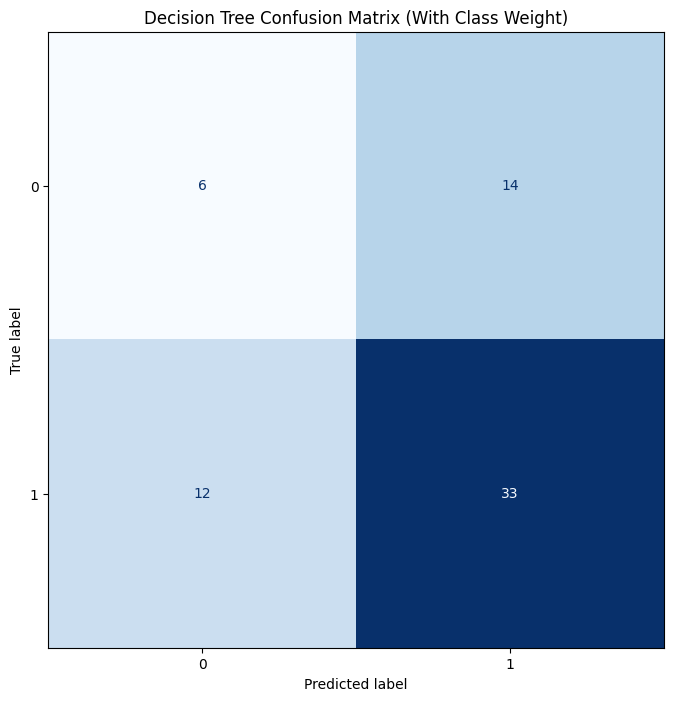

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ambil threshold terbaik dari F1-Score
best_threshold = best_f1['threshold']
y_pred_best = (y_pred_prob > best_threshold).astype(int)

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])

# Visualisasikan
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f"Decision Tree Confusion Matrix (With Class Weight)")
plt.grid(False)
plt.show()

## **Saving The Model**

In [ ]:
# import pickle

# with open('decision_tree_model_final_5.pkl', 'wb') as file:
#     pickle.dump(clf, file)

# print("Model saved successfully.")

## **Load The Model And Predict Data**

In [ ]:
# import pickle

# # Load the model from file
# with open('decision_tree_model_2.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

# # Perform predictions on the test set
# X_test_tf = tfidf_vectorizer.transform(X_test)
# y_pred_loaded = loaded_model.predict(X_test_tf)

# # Calculate classification report
# classification_report_loaded = classification_report(y_test, y_pred_loaded)

# print("Classification Report (Loaded Model):")
# print(classification_report_loaded)

In [ ]:
# # Calculate and display F1 Score
# f1_score_loaded = f1_score(y_test, y_pred_loaded, average='weighted')
# print("F1 Score (Loaded Model):", f1_score_loaded)

# # Calculate and display Accuracy
# accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
# print("Accuracy (Loaded Model):", accuracy_loaded)

# # Calculate and display ROC-AUC Score
# roc_auc_loaded = roc_auc_score(y_test, y_pred_loaded)
# print("ROC-AUC Score (Loaded Model):", roc_auc_loaded)

In [ ]:
# import pickle
# from sklearn.metrics import accuracy_score, classification_report

# # Load the model from file
# with open('decision_tree_model_2.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

# # Transform both training and test sets using the same TF-IDF vectorizer
# X_train_tf = tfidf_vectorizer.transform(X_train)
# X_test_tf = tfidf_vectorizer.transform(X_test)

# # Perform predictions on the training set
# y_train_pred_loaded = loaded_model.predict(X_train_tf)

# # Perform predictions on the test set
# y_test_pred_loaded = loaded_model.predict(X_test_tf)

# # Calculate accuracy for training set
# train_accuracy_loaded = accuracy_score(y_train, y_train_pred_loaded)

# # Calculate accuracy for test set
# test_accuracy_loaded = accuracy_score(y_test, y_test_pred_loaded)

# # Calculate classification report for test set
# classification_report_loaded = classification_report(y_test, y_test_pred_loaded)

# # Print accuracies and classification report
# print(f'Training Accuracy (Loaded Model): {train_accuracy_loaded:.2f}')
# print(f'Test Accuracy (Loaded Model): {test_accuracy_loaded:.2f}')
# print("\nClassification Report (Loaded Model):")
# print(classification_report_loaded)